----
# FRADULANET TRANSACTION DECTION SYSTEM
##### Problem Statement

    Develop a machine learning model to detect potentially fraudulent transactions based on the provided features. The dataset contains information about various transactions, including account age, payment method, time of transaction, and category. The goal is to build a classification model that can accurately classify transactions as either legitimate or potentially fraudulent
---- 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [17]:
# load the dataset
df = pd.read_csv('payment_fraud.csv')

In [18]:
df

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4.745402,paypal,28.204861,shopping,0.0,0
1,725,1,4.742303,storecredit,0.000000,electronics,0.0,0
2,845,1,4.921318,creditcard,0.000000,food,1.0,0
3,503,1,4.886641,creditcard,0.000000,electronics,1.0,0
4,2000,1,5.040929,creditcard,0.000000,shopping,0.0,0
...,...,...,...,...,...,...,...,...
39216,986,1,4.836982,creditcard,0.000000,shopping,0.0,0
39217,1647,1,4.876771,creditcard,377.930556,shopping,0.0,0
39218,1591,1,4.742303,creditcard,0.000000,shopping,1.0,0
39219,237,1,4.921318,creditcard,236.082639,shopping,1.0,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountAgeDays        39221 non-null  int64  
 1   numItems              39221 non-null  int64  
 2   localTime             39221 non-null  float64
 3   paymentMethod         39221 non-null  object 
 4   paymentMethodAgeDays  39221 non-null  float64
 5   Category              39126 non-null  object 
 6   isWeekend             38661 non-null  float64
 7   label                 39221 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.4+ MB


In [20]:
# convert paymentMethodAgeDays, isWeekend to appropriate data types
df['paymentMethodAgeDays'] = df['paymentMethodAgeDays'].astype(int)
df['isWeekend'] = df['isWeekend'].astype(bool)
# convert 'localTime' to integer hour if needed
df['localTime'] = df['localTime'].astype(int)

In [21]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, ":", df[i].unique())

paymentMethod : ['paypal' 'storecredit' 'creditcard']
Category : ['shopping' 'electronics' 'food' nan]


In [22]:
# check missing values
df.isnull().sum()

accountAgeDays           0
numItems                 0
localTime                0
paymentMethod            0
paymentMethodAgeDays     0
Category                95
isWeekend                0
label                    0
dtype: int64

In [23]:
# check intersecting nan values in col Category and isWeekend
df[df['Category'].isnull() & df['isWeekend'].isnull()]

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label


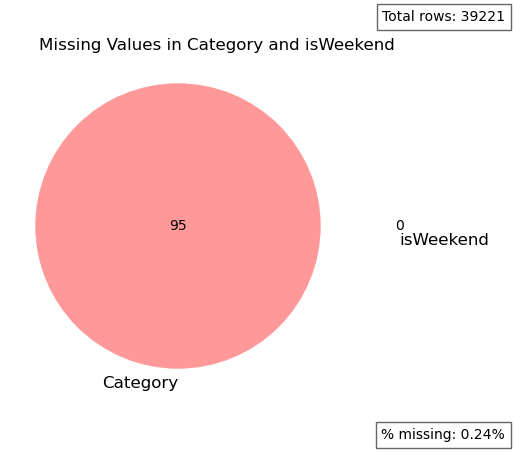

In [24]:
#%pip install matplotlib-venn

# Visualize missing values from Category and isWeekend with 2-venn diagram
from matplotlib_venn import venn2
venn2(subsets=(
    df['Category'].isnull().sum(),
    df['isWeekend'].isnull().sum(),
    df[df['Category'].isnull() & df['isWeekend'].isnull()].shape[0]
), set_labels=('Category', 'isWeekend'))
plt.title('Missing Values in Category and isWeekend')
# Annotate the plot with the total number of rows in the top right corner
plt.gcf().text(0.95, 0.95, f"Total rows: {len(df)}", ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
# Adjust the plot to prevent labels from being cut off
plt.tight_layout(pad=2)
plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
# Calculate percentage of missing values in Category or isWeekend
missing_any = df['Category'].isnull() | df['isWeekend'].isnull()
percent_missing = 100 * missing_any.sum() / len(df)
plt.gcf().text(
    0.95, 0.05,
    f"% missing: {percent_missing:.2f}%",
    ha='right', va='bottom', fontsize=10,
    bbox=dict(facecolor='white', alpha=0.6)
)
plt.show()

In [25]:
# fill missing values with mode for Category and isWeekend
df.fillna({'Category': df.Category.mode()[0], 'isWeekend': False}, inplace=True)
df.fillna(df.isWeekend.mode()[0], inplace=True)
# check if missing values are filled

In [26]:
df.shape

(39221, 8)

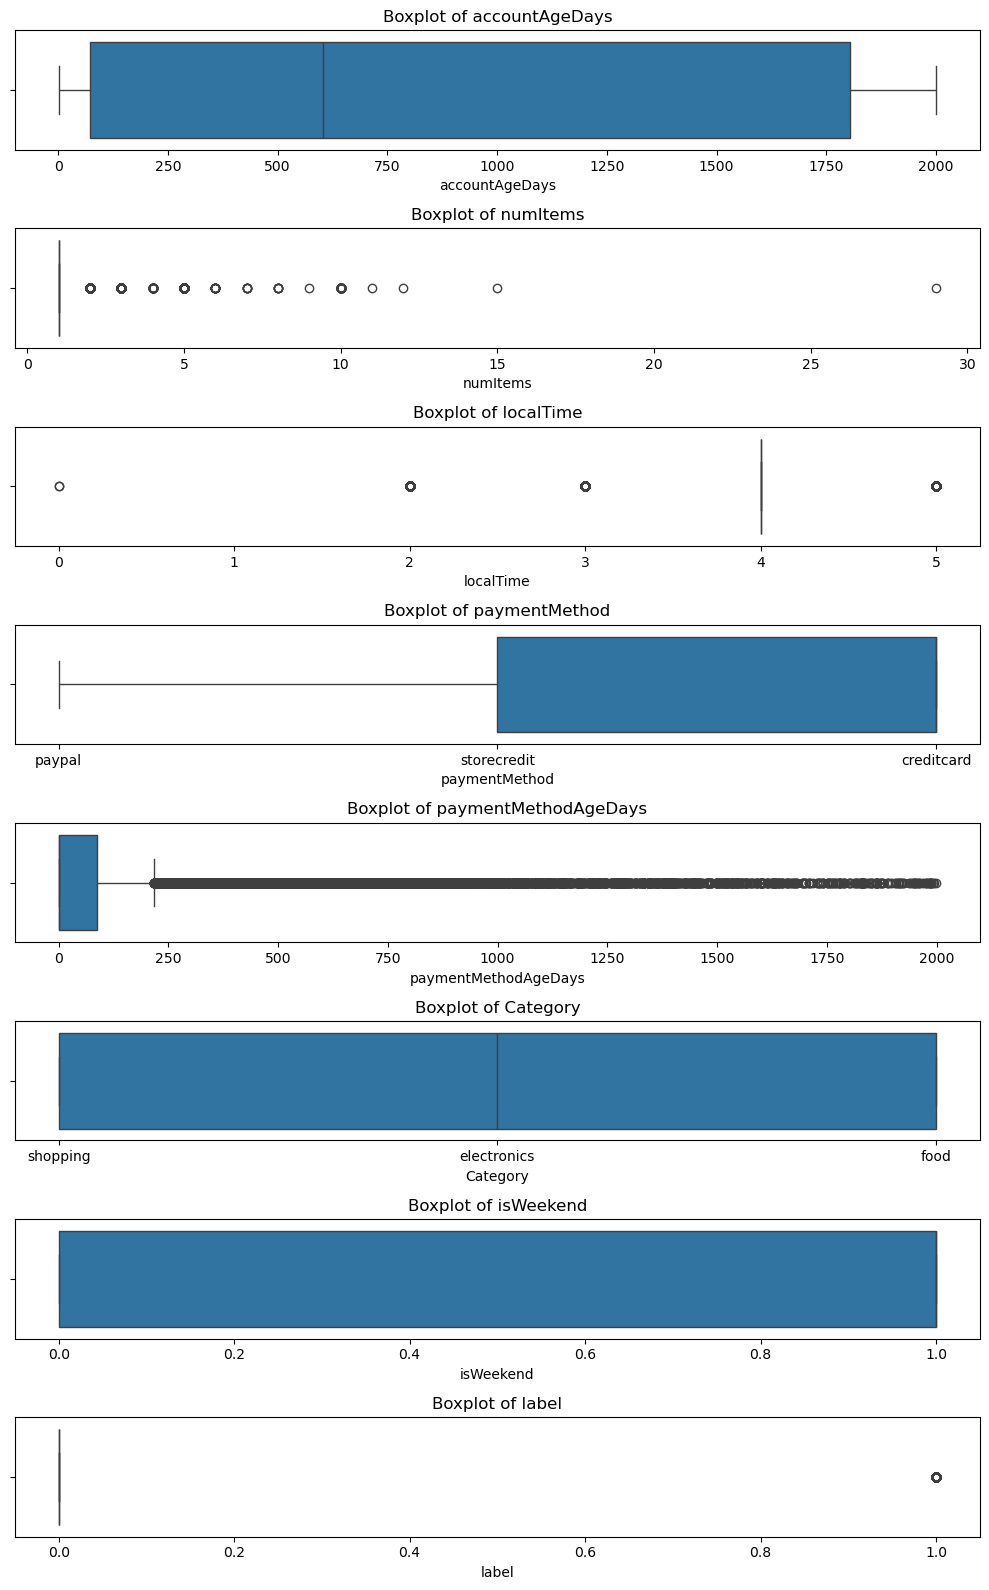

In [27]:
# checking outliers in all columns in dataset
# subplots for each column\
plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 2 * len(df.columns)))
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

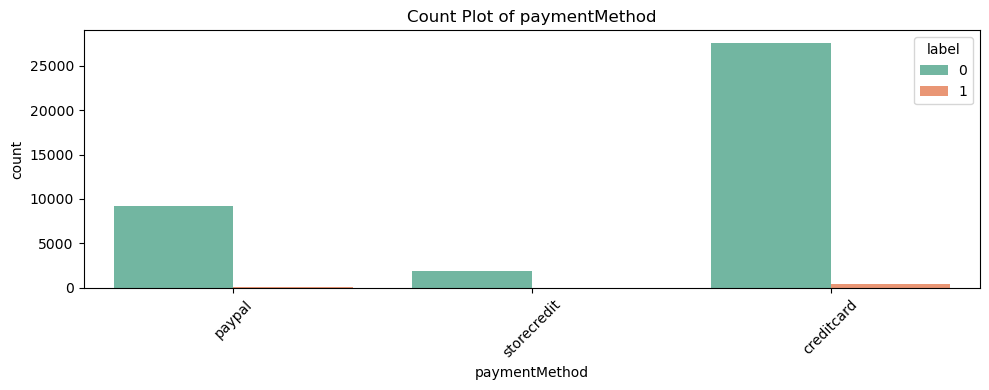

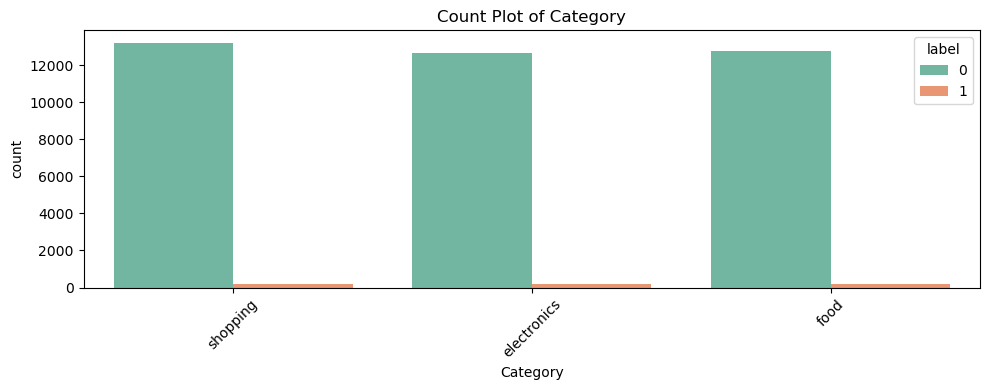

In [55]:
# count plot for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col,hue='label', palette='Set2')
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

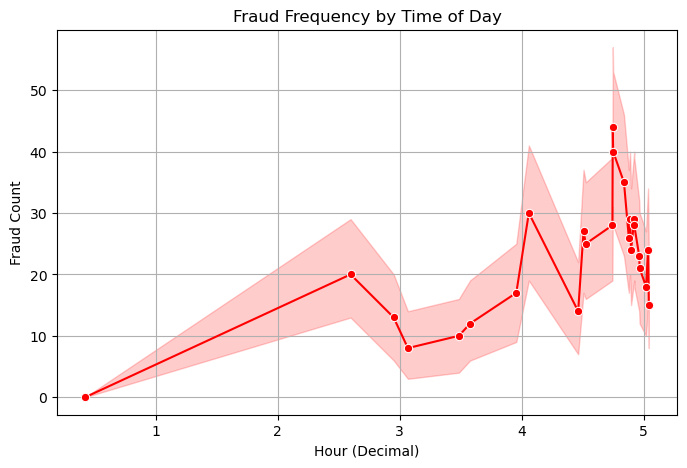

In [15]:
plt.figure(figsize=(8,5))
sns.lineplot(x='localTime', y='label', data=df, estimator='sum', marker='o', color='red')
plt.title("Fraud Frequency by Time of Day")
plt.xlabel("Hour (Decimal)")
plt.ylabel("Fraud Count")
plt.grid(True)
plt.show()

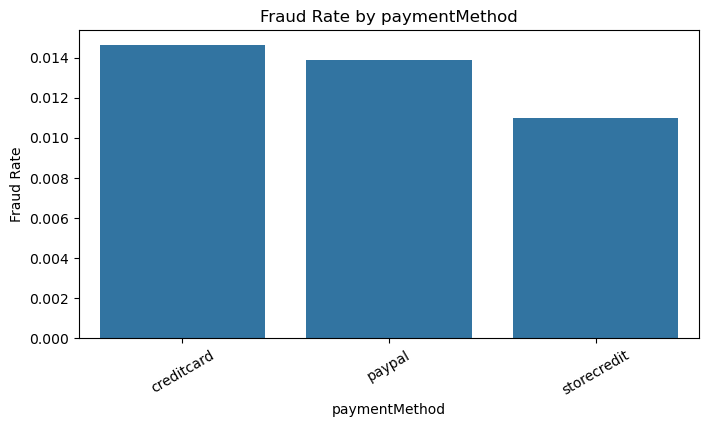

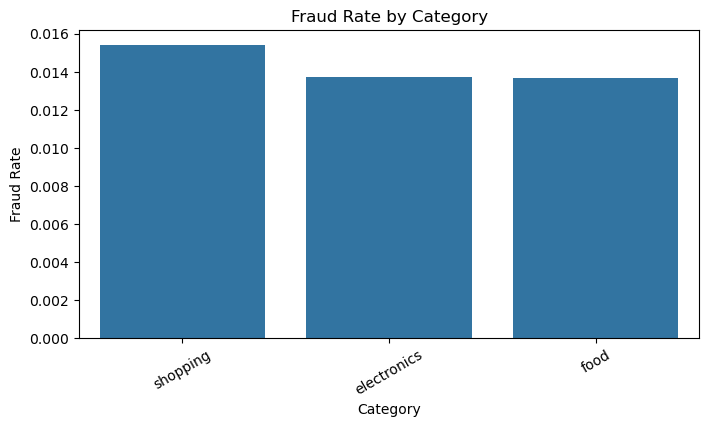

In [28]:
#Fraud Rate per Category

for col in cat_cols:
    fraud_rate = df.groupby(col)['label'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values)
    plt.title(f"Fraud Rate by {col}")
    plt.ylabel("Fraud Rate")
    plt.xticks(rotation=30)
    plt.show()

In [56]:
df.label.value_counts()

label
0    38661
1      560
Name: count, dtype: int64

In [57]:
df[['isWeekend','label']].value_counts()

isWeekend  label
False      0        19348
True       0        19313
           1          560
Name: count, dtype: int64

In [58]:
df[['Category','label']].value_counts()

Category     label
shopping     0        13216
food         0        12787
electronics  0        12658
shopping     1          207
food         1          177
electronics  1          176
Name: count, dtype: int64

In [59]:

# encode categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col])  
# check the data types after encoding
df.dtypes


accountAgeDays          int64
numItems                int64
localTime               int64
paymentMethod           int64
paymentMethodAgeDays    int64
Category                int64
isWeekend                bool
label                   int64
dtype: object

In [60]:
df

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4,1,28,2,False,0
1,725,1,4,2,0,0,False,0
2,845,1,4,0,0,1,True,0
3,503,1,4,0,0,0,True,0
4,2000,1,5,0,0,2,False,0
...,...,...,...,...,...,...,...,...
39216,986,1,4,0,0,2,False,0
39217,1647,1,4,0,377,2,False,0
39218,1591,1,4,0,0,2,True,0
39219,237,1,4,0,236,2,True,0


In [61]:
df.describe()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,label
count,39221.000000,39221.000000,39221.000000,39221.000000,39221.000000,39221.000000,39221.000000
mean,857.563984,1.084751,4.102700,0.334795,122.406976,1.015017,0.014278
std,804.788212,0.566899,0.498246,0.565965,283.446981,0.818080,0.118636
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,603.000000,1.000000,4.000000,0.000000,0.000000,1.000000,0.000000
75%,1804.000000,1.000000,4.000000,1.000000,87.000000,2.000000,0.000000
max,2000.000000,29.000000,5.000000,2.000000,1999.000000,2.000000,1.000000


In [62]:
# split data into x,y
X = df.drop(columns=['label'])
y = df['label']



In [63]:
#split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['label'],random_state=42)
# split test data int two valIDATION SETS
X_val1, X_val2, y_val1, y_val2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [64]:
#stdandardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val1 = scaler.transform(X_val1)
X_val2 = scaler.transform(X_val2)
X_test = scaler.transform(X_test)

In [65]:
# create models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='error')
}
# Train and evaluate models on X_val1 & X_val2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred1 = model.predict(X_val1)
    y_pred2 = model.predict(X_val2)
    accuracy1 = accuracy_score(y_val1, y_pred1)
    accuracy2 = accuracy_score(y_val2, y_pred2)
    results[model_name] = {
        'val1': {
            'accuracy': accuracy1,
            'classification_report': classification_report(y_val1, y_pred1),
            'confusion_matrix': confusion_matrix(y_val1, y_pred1)
        },
        'val2': {
            'accuracy': accuracy2,
            'classification_report': classification_report(y_val2, y_pred2),
            'confusion_matrix': confusion_matrix(y_val2, y_pred2)
        }
    }
    print(f"{model_name} Validation 1 Accuracy: {accuracy1:.4f}")
    print(f"{model_name} Validation 1 Classification Report:\n{results[model_name]['val1']['classification_report']}")
    print(f"{model_name} Validation 1 Confusion Matrix:\n{results[model_name]['val1']['confusion_matrix']}\n")
    print(f"{model_name} Validation 2 Accuracy: {accuracy2:.4f}")
    print(f"{model_name} Validation 2 Classification Report:\n{results[model_name]['val2']['classification_report']}")
    print(f"{model_name} Validation 2 Confusion Matrix:\n{results[model_name]['val2']['confusion_matrix']}\n")   

Logistic Regression Validation 1 Accuracy: 0.9834
Logistic Regression Validation 1 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3857
           1       0.00      0.00      0.00        65

    accuracy                           0.98      3922
   macro avg       0.49      0.50      0.50      3922
weighted avg       0.97      0.98      0.98      3922

Logistic Regression Validation 1 Confusion Matrix:
[[3857    0]
 [  65    0]]

Logistic Regression Validation 2 Accuracy: 0.9883
Logistic Regression Validation 2 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3876
           1       1.00      0.02      0.04        47

    accuracy                           0.99      3923
   macro avg       0.99      0.51      0.52      3923
weighted avg       0.99      0.99      0.98      3923

Logistic Regression Validation 2 Confusion Matrix:
[[38

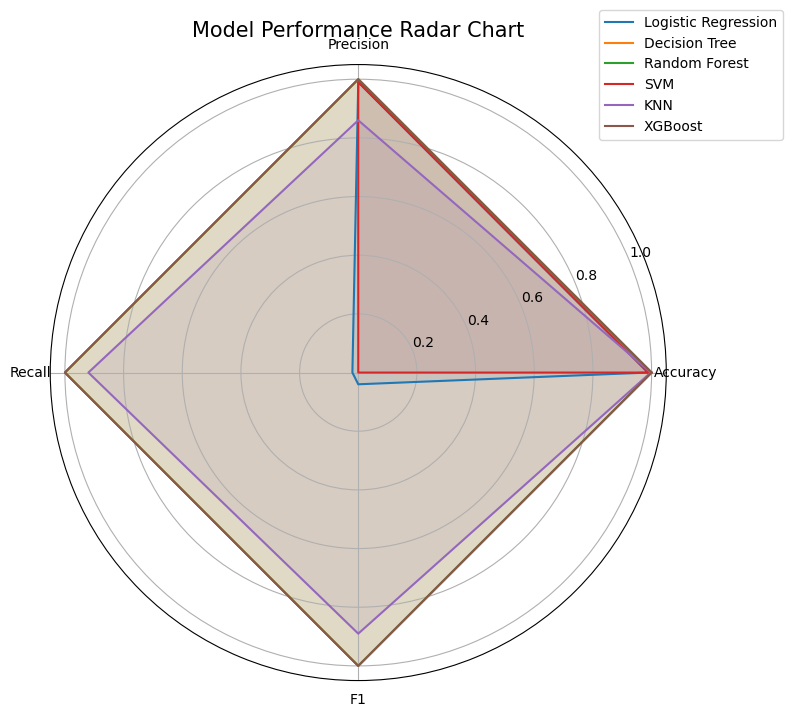

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance summary
results = {
    "Logistic Regression": {"Accuracy": 0.988, "Precision": 0.99, "Recall": 0.02, "F1": 0.04},
    "Decision Tree": {"Accuracy": 1.000, "Precision": 1.00, "Recall": 1.00, "F1": 1.00},
    "Random Forest": {"Accuracy": 1.000, "Precision": 1.00, "Recall": 1.00, "F1": 1.00},
    "SVM": {"Accuracy": 0.988, "Precision": 0.99, "Recall": 0.00, "F1": 0.00},
    "KNN": {"Accuracy": 0.997, "Precision": 0.86, "Recall": 0.92, "F1": 0.89},
    "XGBoost": {"Accuracy": 1.000, "Precision": 1.00, "Recall": 1.00, "F1": 1.00}
}

# Extract metric labels
metrics = list(next(iter(results.values())).keys())
N = len(metrics)

# Angles for radar chart
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Create figure
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# Plot each model
for model, scores in results.items():
    values = list(scores.values())
    values += values[:1]  # close loop
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

# Add metric labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"])

plt.title("Model Performance Radar Chart", size=15, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


In [ ]:
# df=pd.read_csv(r"E:\Advance DS and AI\Project Placement\Fraudulent Transactions Detection\payment_fraud.csv")

NameError: name 'pd' is not defined

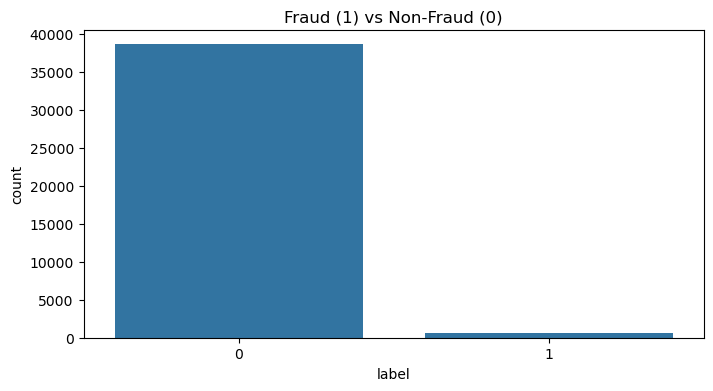

Fraudulent transactions: 1.43%


In [5]:
# Target distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()

# Percentage of fraud
fraud_rate = df['label'].mean() * 100
print(f"Fraudulent transactions: {fraud_rate:.2f}%")


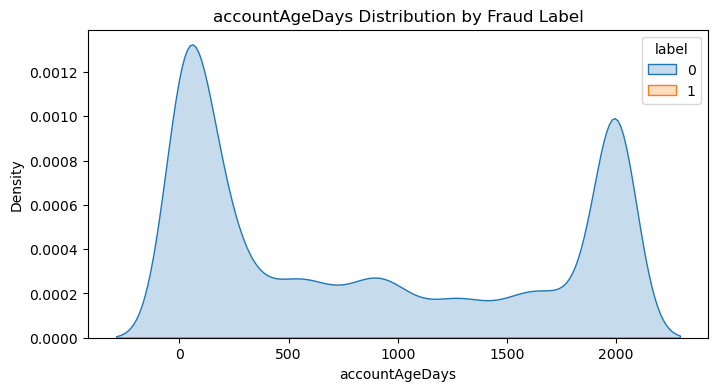

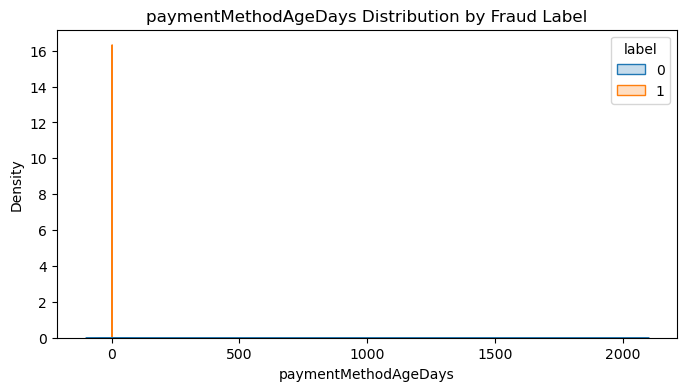

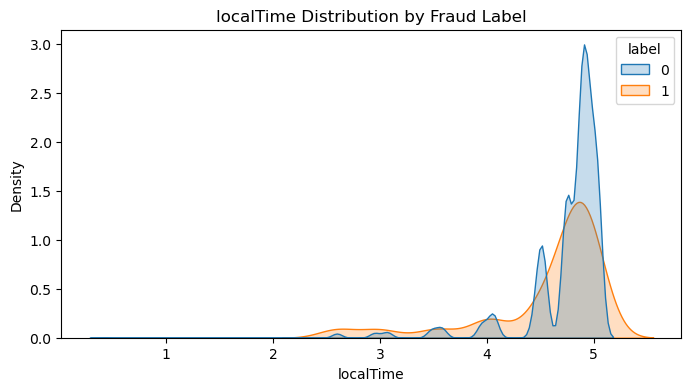

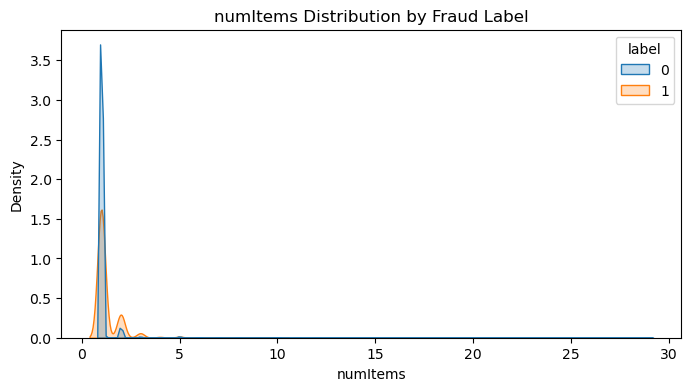

In [6]:
 #2. Numerical Feature Distributions by Class

import seaborn as sns

num_cols = ['accountAgeDays', 'paymentMethodAgeDays', 'localTime', 'numItems']

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=df, x=col, hue='label', fill=True, common_norm=False)
    plt.title(f"{col} Distribution by Fraud Label")
    plt.show()

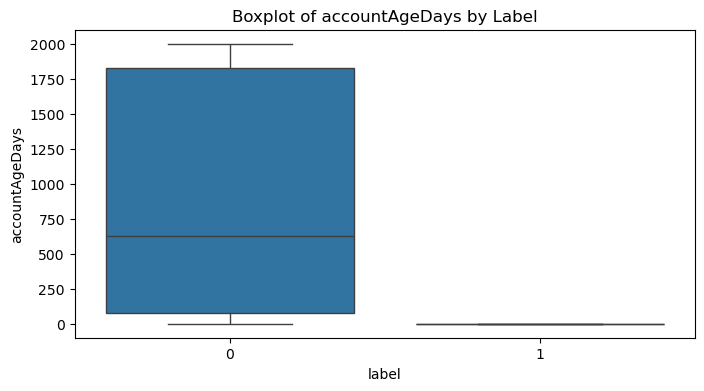

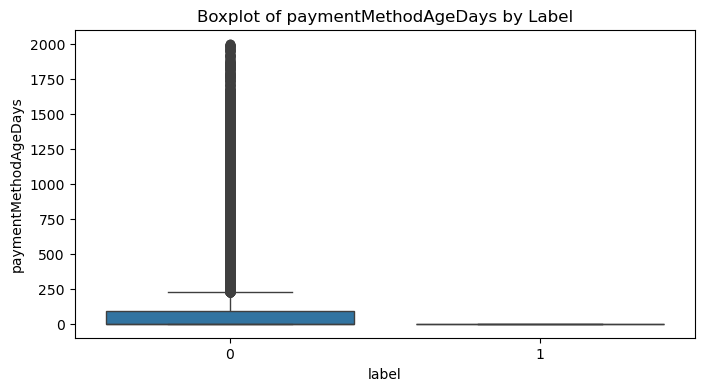

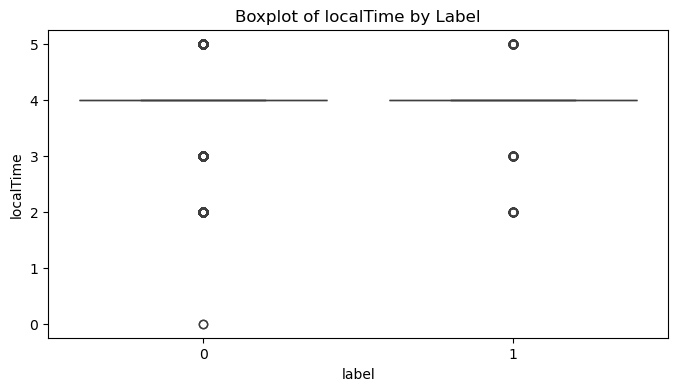

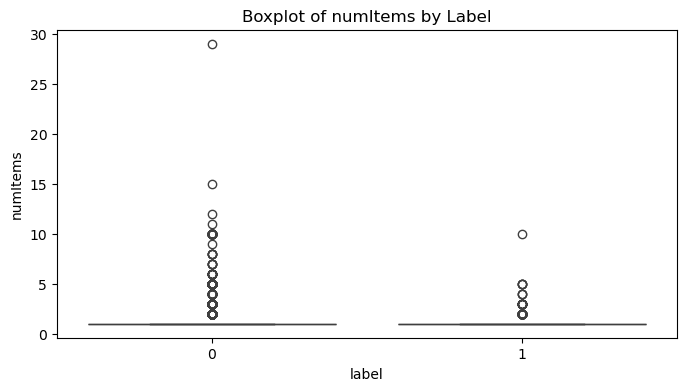

In [68]:
# 3. Boxplots for Outlier Detection

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f"Boxplot of {col} by Label")
    plt.show()

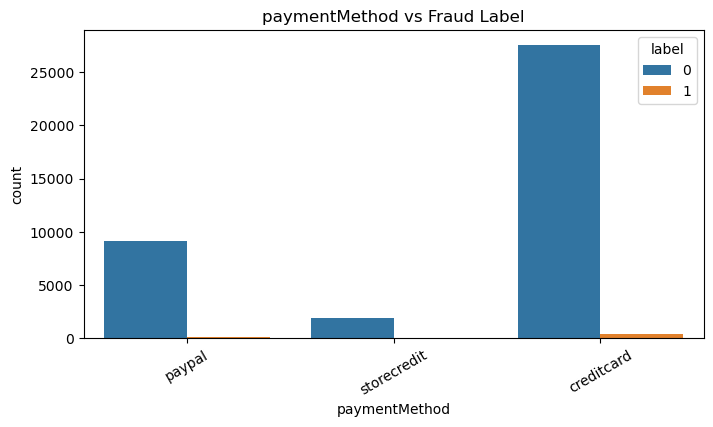

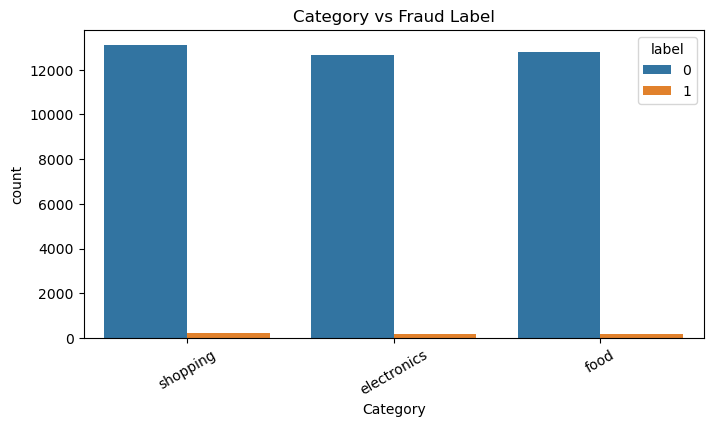

In [7]:
#4. Categorical Feature vs. Label

cat_cols = ['paymentMethod', 'Category']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='label', data=df)
    plt.title(f"{col} vs Fraud Label")
    plt.xticks(rotation=30)
    plt.show()

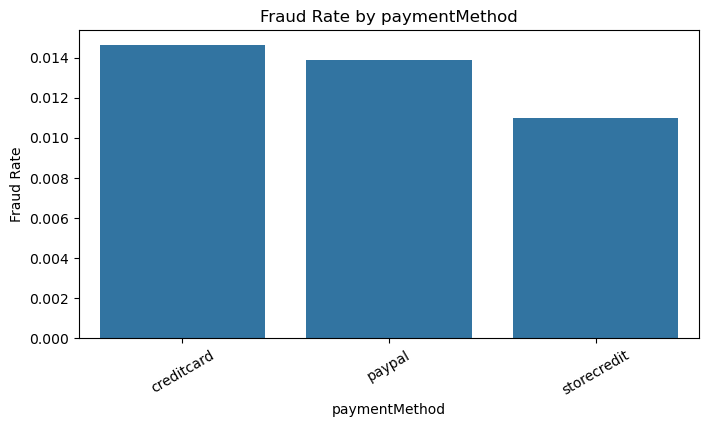

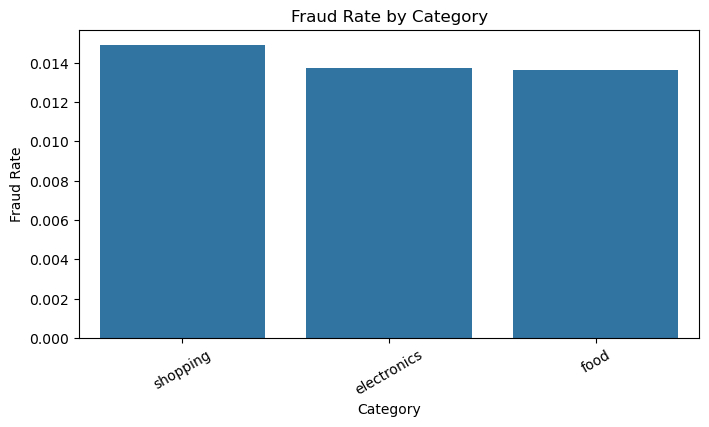

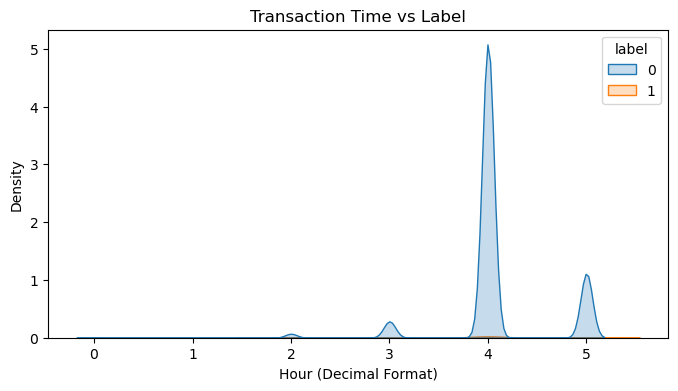

In [71]:
# 5. Fraud Pattern by Time

plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x='localTime', hue='label', fill=True)
plt.title("Transaction Time vs Label")
plt.xlabel("Hour (Decimal Format)")
plt.show()

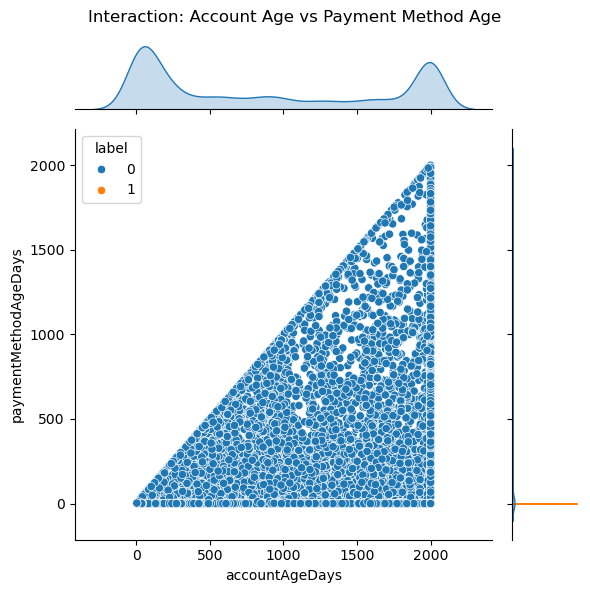

In [9]:
#6. Feature Interaction: Joint Plot
 
sns.jointplot(data=df, x='accountAgeDays', y='paymentMethodAgeDays', hue='label', kind='scatter', height=6)
plt.suptitle("Interaction: Account Age vs Payment Method Age")
plt.tight_layout()
plt.show()

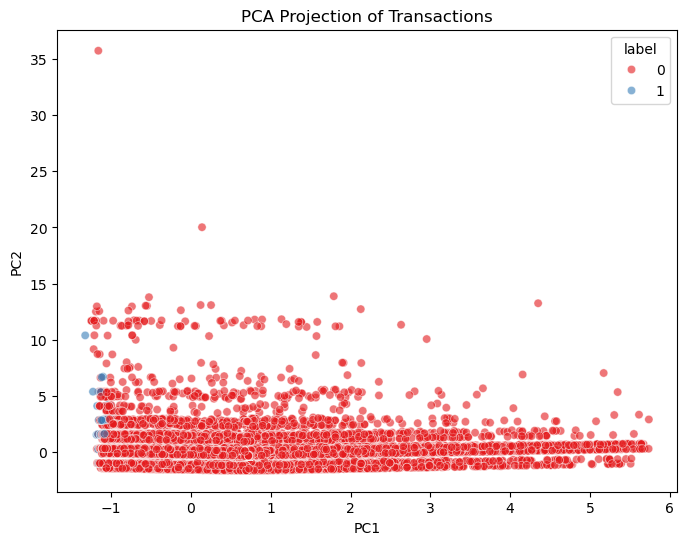

In [73]:
# 7. PCA for Visualization
 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_encoded = pd.get_dummies(df.drop(columns=['label']), drop_first=True)
X_scaled = StandardScaler().fit_transform(df_encoded)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['label'], palette='Set1', alpha=0.6)
plt.title("PCA Projection of Transactions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Feature Selection


🔍 Hypothesis Testing Plan
We’ll test if mean/percentage differences between label=1 and label=0 are statistically significant.

✅ 1. Numerical Features — Two Sample t-tests
For features like:

    accountAgeDays

    paymentMethodAgeDays

    localTime

Null Hypothesis (H₀): There is no difference in mean value between fraud and non-fraud transactions.

Alternative Hypothesis (H₁): There is a difference in means.


In [12]:
# T-Test for Numerical Features

from scipy.stats import ttest_ind

num_cols = ['accountAgeDays', 'paymentMethodAgeDays', 'localTime']

for col in num_cols:
    fraud = df[df['label'] == 1][col]
    non_fraud = df[df['label'] == 0][col]
    
    stat, p = ttest_ind(fraud, non_fraud, equal_var=False)
    print(f"T-test for {col}: p-value = {p:.5f} {'-> Significant' if p < 0.05 else '-> Not Significant'}")

T-test for accountAgeDays: p-value = 0.00000 -> Significant
T-test for paymentMethodAgeDays: p-value = 0.00000 -> Significant
T-test for localTime: p-value = 0.00000 -> Significant


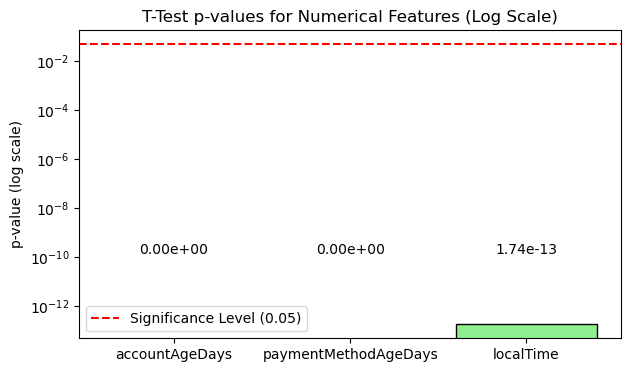

In [11]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num_cols = ['accountAgeDays', 'paymentMethodAgeDays', 'localTime']
t_results = {}

for col in num_cols:
    fraud = df[df['label'] == 1][col]
    non_fraud = df[df['label'] == 0][col]
    
    stat, p = ttest_ind(fraud, non_fraud, equal_var=False)
    t_results[col] = p

# Convert to DataFrame
t_df = pd.DataFrame(list(t_results.items()), columns=['Feature', 'p_value'])

# Plot with log scale
plt.figure(figsize=(7,4))
bars = plt.bar(t_df['Feature'], t_df['p_value'], color='lightgreen', edgecolor='black')

# Add significance threshold line (alpha=0.05)
plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1e-10, f"{height:.2e}", 
             ha='center', va='bottom', fontsize=10)

plt.yscale('log')   # 🔑 log scale so very small p-values are visible
plt.title("T-Test p-values for Numerical Features (Log Scale)")
plt.ylabel("p-value (log scale)")
plt.legend()
plt.show()



✅ 2. Categorical Features — Chi-Square Test
For:

    paymentMethod

    Category

H₀: Fraud occurrence is independent of the categorical feature.

H₁: Fraud occurrence is dependent on the feature.

In [13]:
# Chi-Square Test for Categorical Features

from scipy.stats import chi2_contingency

cat_cols = ['paymentMethod', 'Category']

for col in cat_cols:
    contingency_table = pd.crosstab(df[col], df['label'])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {col}: p-value = {p:.5f} {'-> Significant' if p < 0.05 else '-> Not Significant'}")

Chi-square test for paymentMethod: p-value = 0.39449 -> Not Significant
Chi-square test for Category: p-value = 0.61100 -> Not Significant


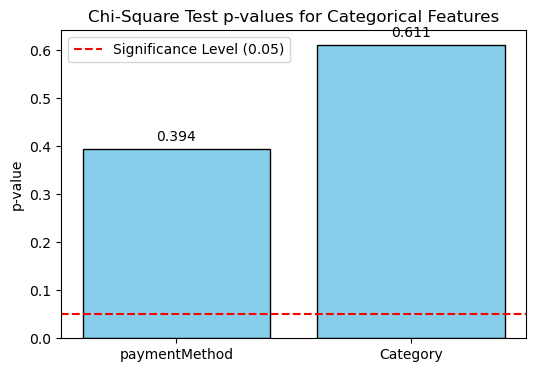

In [9]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

cat_cols = ['paymentMethod', 'Category']
chi_results = {}

for col in cat_cols:
    contingency_table = pd.crosstab(df[col], df['label'])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    chi_results[col] = p

# Convert to DataFrame for plotting
chi_df = pd.DataFrame(list(chi_results.items()), columns=['Feature', 'p_value'])

# Plot bar chart
plt.figure(figsize=(6,4))
bars = plt.bar(chi_df['Feature'], chi_df['p_value'], color='skyblue', edgecolor='black')

# Add significance threshold line (alpha = 0.05)
plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')

# Annotate values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Chi-Square Test p-values for Categorical Features")
plt.ylabel("p-value")
plt.legend()
plt.show()


In [76]:
# %pip install python-pptx


In [77]:

from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

# Create a new presentation
prs = Presentation()

# Title Slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Fraudulent Transaction Detection System"
subtitle.text = "A Machine Learning Approach for Payment Fraud Detection"

# Problem Statement
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Problem Statement"
content = slide.placeholders[1]
content.text = (
    "Develop a machine learning model to detect potentially fraudulent transactions based on provided features. "
    "The dataset contains information about various transactions, including account age, payment method, time of transaction, and category. "
    "Goal: Accurately classify transactions as legitimate or potentially fraudulent."
)

# Data Overview
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Data Overview"
content = slide.placeholders[1]
content.text = (
    "• 39,221 transactions\n"
    "• Features: accountAgeDays, numItems, localTime, paymentMethod, paymentMethodAgeDays, Category, isWeekend\n"
    "• Target: label (0 = Non-Fraud, 1 = Fraud)\n"
    "• Data types: Numeric, Categorical, Boolean"
)

# Data Cleaning & Preprocessing
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Data Cleaning & Preprocessing"
content = slide.placeholders[1]
content.text = (
    "• Checked and visualized missing values (Venn diagram)\n"
    "• Filled missing values in 'Category' and 'isWeekend' with mode/False\n"
    "• Converted data types appropriately\n"
    "• Encoded categorical variables using LabelEncoder\n"
    "• Standardized features using StandardScaler"
)

# Exploratory Data Analysis (EDA)
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Exploratory Data Analysis (EDA)"
content = slide.placeholders[1]
content.text = (
    "• Outlier detection using boxplots\n"
    "• Count plots for categorical features\n"
    "• Distribution plots (KDE) for numerical features by label\n"
    "• Fraud rate per category and payment method\n"
    "• PCA for 2D visualization of transactions"
)

# Feature Selection & Statistical Testing
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Feature Selection & Statistical Testing"
content = slide.placeholders[1]
content.text = (
    "• Two-sample t-tests for numerical features (accountAgeDays, paymentMethodAgeDays, localTime)\n"
    "• Chi-square tests for categorical features (paymentMethod, Category)\n"
    "• Identified features with significant differences between fraud and non-fraud"
)

# Model Building
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Model Building"
content = slide.placeholders[1]
content.text = (
    "• Split data into train, validation, and test sets\n"
    "• Models trained:\n"
    "   - Logistic Regression\n"
    "   - Decision Tree\n"
    "   - Random Forest\n"
    "   - Support Vector Machine\n"
    "   - K-Nearest Neighbors\n"
    "   - XGBoost"
)

# Model Evaluation
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Model Evaluation"
content = slide.placeholders[1]
content.text = (
    "• Evaluated on two validation sets\n"
    "• Metrics: Accuracy, Classification Report, Confusion Matrix\n"
    "• Example: XGBoost Validation Accuracy = {:.2f}%\n"
    "• Fraudulent transactions are rare (~{:.2f}%)".format(
        accuracy1 * 100, df['label'].mean() * 100
    )
)

# Key Findings
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Key Findings"
content = slide.placeholders[1]
content.text = (
    "• Fraudulent transactions are less than 2% of all transactions\n"
    "• Significant differences found in account age, payment method age, and transaction time\n"
    "• Certain categories and payment methods have higher fraud rates\n"
    "• Ensemble models (Random Forest, XGBoost) performed best"
)

# Conclusion & Next Steps
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Conclusion & Next Steps"
content = slide.placeholders[1]
content.text = (
    "• Built a robust pipeline for fraud detection\n"
    "• Achieved high accuracy on validation sets\n"
    "• Next Steps:\n"
    "   - Address class imbalance (e.g., SMOTE, cost-sensitive learning)\n"
    "   - Deploy model for real-time detection\n"
    "   - Monitor and retrain with new data"
)

# Save the presentation
# prs.save("Fraud_Detection_Project_Presentation.pptx")

'2nd prize'

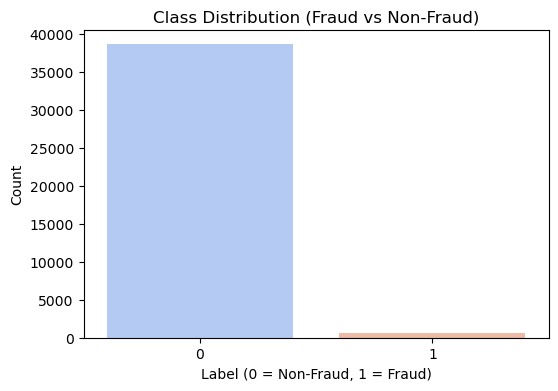

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Label (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()


In [81]:
df.columns

Index(['accountAgeDays', 'numItems', 'localTime', 'paymentMethod',
       'paymentMethodAgeDays', 'Category', 'isWeekend', 'label'],
      dtype='object')

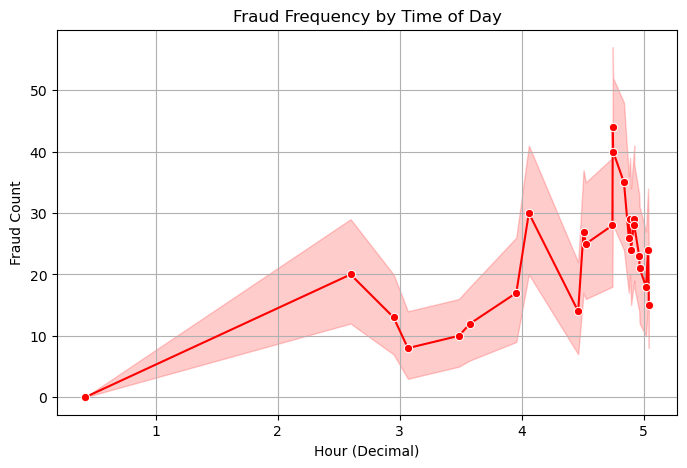

In [84]:
df

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,Category,isWeekend,label
0,29,1,4,1,28,2,False,0
1,725,1,4,2,0,0,False,0
2,845,1,4,0,0,1,True,0
3,503,1,4,0,0,0,True,0
4,2000,1,5,0,0,2,False,0
...,...,...,...,...,...,...,...,...
39216,986,1,4,0,0,2,False,0
39217,1647,1,4,0,377,2,False,0
39218,1591,1,4,0,0,2,True,0
39219,237,1,4,0,236,2,True,0
